# Stellar Classification

**Author:** Esteban Duran

**Description:** The classification of cosmic entities is a fundamental problem
in astronomy. In this project we will be using machine learning techniques to
create a classification model that can reliably classify the cosmic entities of
galaxy, quasar, and star from the [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)
dataset taken by the [ Sloan Digital Sky Survey (SDSS)](https://www.sdss.org).
The dataset contains 100,000 observations where each observation consists of
17 feature columns and 1 class column. The algorithms we will be using include:

- Logistic Regression (baseline)
- Decision Tree
- Random Forest

I will be comparing these algorithms against each other and selecting the one
that ends up performing the best.

The following describes our dataset features:
1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

**Dataset:** [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

**Acknowledgements**: [Official Stellar Classification Notebook](https://www.kaggle.com/code/navdeepjakhar/stellar-classification-comparing-6-algorithms)

## Setup

In [1]:
# Import all the modules we will need
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastcore.all import *

from imblearn.over_sampling import SMOTE

from utils.draw import draw_tree
from utils import parks_ranger

import seaborn as sns

from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import torch, numpy as np, pandas as pd

# Set print options to conform to the notebook width
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# ! We need this to get some of the training output to work. This will be fixed
# in a future release of Jupyter for VS Code.
# https://github.com/microsoft/vscode-jupyter/pull/13442#issuecomment-1541584881
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch

random.seed(42)
torch.manual_seed(42)

## Load Data

Lets start by first downloading our dataset from Kaggle.

In [2]:
dataset_name = "fedesoriano/stellar-classification-dataset-sdss17"
dataset_path = URLs.path(dataset_name)

dataset_path

Path('/root/.fastai/archive/stellar-classification-dataset-sdss17')

In [3]:
Path.BASE_PATH = dataset_path

In [4]:
# Download the dataset to a hidden folder and extract it from kaggle
if not dataset_path.exists() or not any(Path(dataset_path).iterdir()):
    import kaggle

    dataset_path.mkdir(parents=True, exist_ok=True)
    kaggle.api.dataset_download_cli(dataset_name, path=dataset_path, unzip=True)

dataset_path.ls()

(#1) [Path('star_classification.csv')]

Now that we have downloaded our data we can load it into a Pandas DataFrame.

In [5]:
stellar_df = pd.read_csv(dataset_path / "star_classification.csv", low_memory=False)
stellar_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## Data Analysis

Lets now dive into some data analysis and take a look at what we are working with.

In [6]:
stellar_df.shape

(100000, 18)

We can see that we have 100,000 observations with 18 columns where 17 of the
columns are feature columns and the 18th is the label or target.

Now lets see if we have any null values in our dataset that we need to substitute.

In [7]:
stellar_df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

We have none! That's great news!

In [8]:
stellar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

We can see from this summary that our class is actually an object type. We need
it to be some numerical value.

In [9]:
stellar_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


We can also see that some of the values of our features are very very large. Take
`alpha` with a max value of 359.99. We might need to normalize those later on.

Lets now take a closer look at that `class` column.

In [10]:
stellar_df["class"].nunique()

3

In [11]:
stellar_df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

We can notice a class imbalance with significantly more galaxy classes than stars
and even more than quasars. We'll need to fix this with some resampling later on.

Lets now proceed to visualize some of our features.

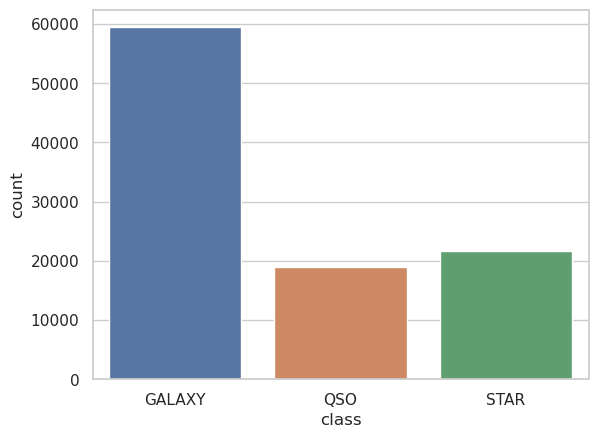

In [12]:
sns.countplot(x=stellar_df["class"])
plt.show()

Lets take a look at the density distribution of the [declination angle](https://en.wikipedia.org/wiki/Declination) **δ**.

The declination angle is one of the two angles that locate a point on the
celestial sphere in the equatorial coordinate system. It can be thought of as
representing longitude.

<Axes: xlabel='delta', ylabel='Density'>

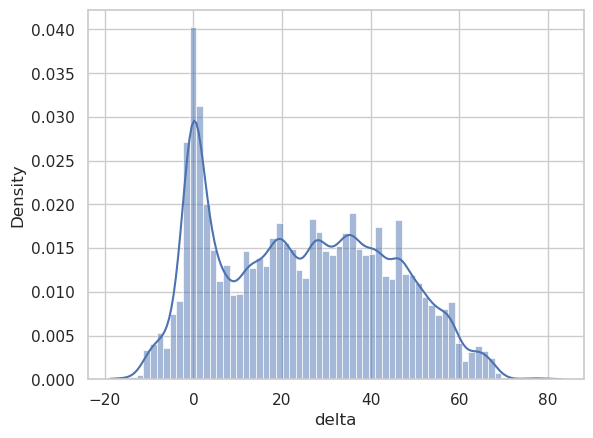

In [13]:
sns.histplot(stellar_df.delta, stat="density", kde=True)

Lets take a look at the density distribution of the [redshift](https://en.wikipedia.org/wiki/Redshift).

<Axes: xlabel='redshift', ylabel='Density'>

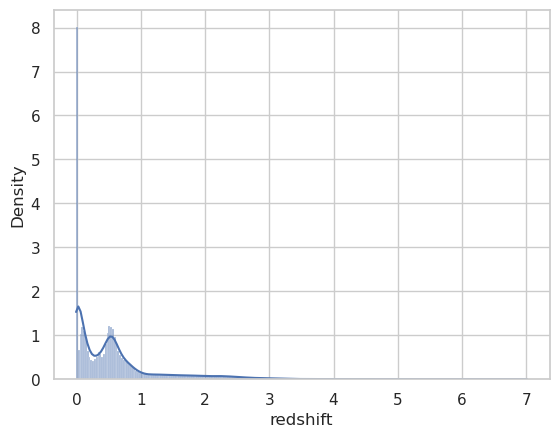

In [14]:
sns.histplot(stellar_df.redshift, stat="density", kde=True)

Now lets take a look at the density distribution of the plate.

<Axes: xlabel='plate', ylabel='Density'>

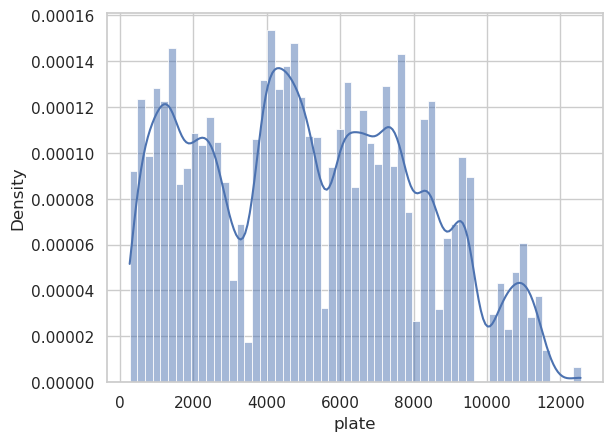

In [15]:
sns.histplot(stellar_df.plate, stat="density", kde=True)

We can also take a look at the scatterplot of the right ascension, **α**, and the
declination angle.

<Axes: xlabel='alpha', ylabel='delta'>

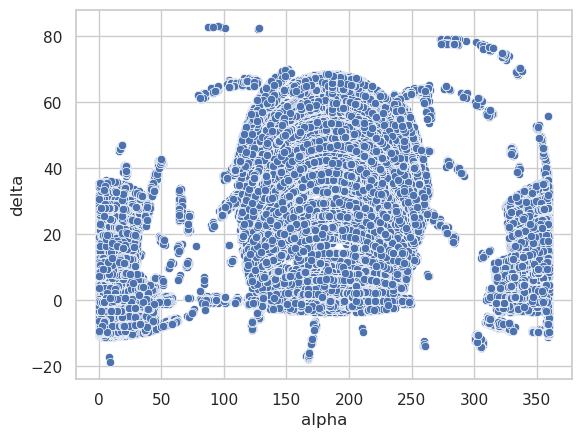

In [16]:
sns.scatterplot(x=stellar_df.alpha, y=stellar_df.delta)

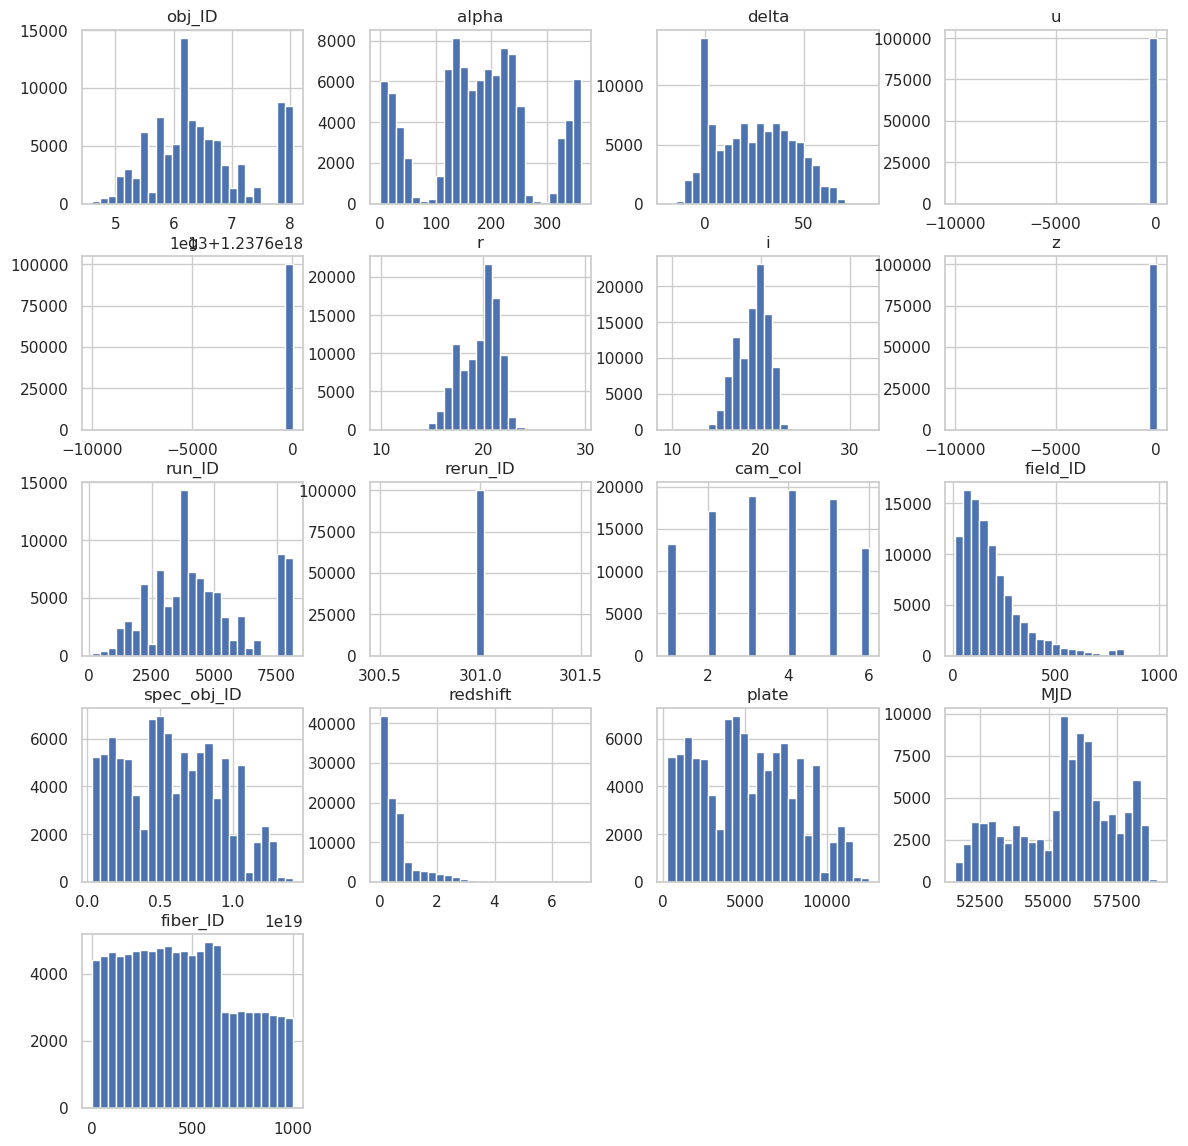

In [17]:
stellar_df.hist(bins=25, figsize=(14, 14))
plt.show()

We can also take a look at the heatmap for expressing correlation.

<Axes: >

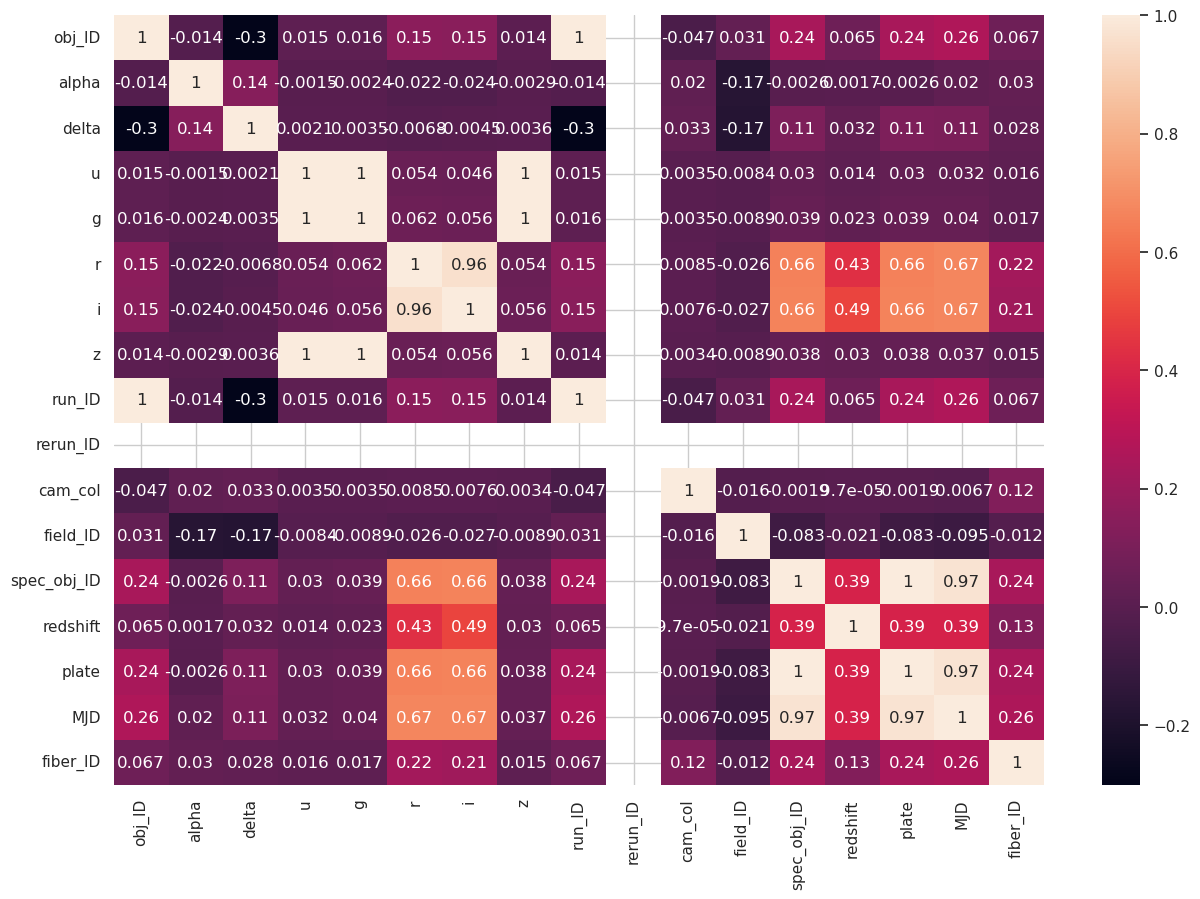

In [18]:
plt.figure(figsize=(15, 10))
corr = stellar_df.drop(["class"], axis=1).corr()
sns.heatmap(corr, annot=True)

## Data Preprocessing

In this section we will prepare our dataset so that a machine learning model
is able to take it as input.

### Encoding

You might remember that earlier we pointed out that our `class` column would
need to be converted to a numerical value. This is because machine learning
models prefer and some, like neural networks, require that all inputs be
numerical values. To achieve this we will need to encode our `class` values.

There are two popular approaches for encoding categorical values. The first
is label encoding which just takes the list of categories and assigns them a 
value from zero to number of categories minus one. This is very simple but it
can lead to models thinking that one class is more important than the other.
The second approach is one-hot encoding which creates a new column for each
category and fills in the values with either a zero or a one. This approach
resolves the issues with label encoding but if there are a lot of categories 
there will be a lot of new columns.

For this project we will be using one-hot encoding since our data is not ordinal.
To start we first need to convert our `class` column from an `object` type to a `category` type.

In [19]:
stellar_df["class"] = stellar_df["class"].astype("category")

stellar_df["class"].dtype

CategoricalDtype(categories=['GALAXY', 'QSO', 'STAR'], ordered=False)

In [20]:
stellar_df["class"].head()

0    GALAXY
1    GALAXY
2    GALAXY
3    GALAXY
4    GALAXY
Name: class, dtype: category
Categories (3, object): ['GALAXY', 'QSO', 'STAR']

In [21]:
stellar_df["class"].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

### Feature Selection

In the following section we will select a subset of features for training our
models.

In [22]:
X = stellar_df[["u", "g", "r", "i", "z", "redshift", "plate"]]
X

,u,g,r,i,z,redshift,plate
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374
99996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626
99997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764
99998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751


In [23]:
y = stellar_df["class"]

### Normalization

You may have noticed some of the values we have for features like the filters
are significantly larger than other features like redshift. This can cause
problems in our classifiers since one or a couple of features can end up
dominating the other features. We'll want to now normalize the feature values
to hover around zero.

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

scaled = scaler.fit_transform(X)
X_norm = pd.DataFrame(scaled, columns=X.columns)

X_norm

,u,g,r,i,z,redshift,plate
0,0.999113,0.999070,0.535344,0.427665,0.998944,0.091831,0.451592
1,0.999202,0.999126,0.646203,0.515986,0.999225,0.112389,0.828841
2,0.999251,0.999109,0.546218,0.435729,0.998959,0.093170,0.350949
3,0.998939,0.999220,0.596946,0.486717,0.998990,0.134210,0.723312
4,0.998670,0.998602,0.337999,0.287021,0.998620,0.017959,0.476753
...,...,...,...,...,...,...,...
99995,0.998942,0.999140,0.611752,0.522045,0.999138,0.001420,0.741633
99996,0.998994,0.999081,0.538130,0.453770,0.999006,0.059087,0.599300
99997,0.998842,0.998771,0.424420,0.362588,0.998800,0.021839,0.203404
99998,0.999259,0.999007,0.510982,0.423554,0.998927,0.066229,0.528051


You can see that all of our feature values are between [0, 1]. This will help
the classifier and boost the performance.

### Resampling

You might remember that earlier we had discussed the imbalance of the dataset
with there being significantly more galaxies than quasars and stars. This can
introduce significant bias in our model where it's able to classify galaxies
very well but not the other entities. One way to fix this issue is with
[resampling](https://en.wikipedia.org/wiki/Resampling_(statistics)).
Specifically, we will be using [SMOTE](https://arxiv.org/abs/1106.1813) to 
balance out our dataset.

> Checkout [this](https://rikunert.github.io/SMOTE_explained) great SMOTE explainer

In [25]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_norm, y)

In [26]:
y.value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [27]:
y_resampled.value_counts()

class
GALAXY    59445
QSO       59445
STAR      59445
Name: count, dtype: int64

## Dataset Split

Now that we have our dataset resampled and balanced we can proceed with actually
splitting our dataset into a training and validation subset. We will be taking
25% of our data and setting it aside for validation.

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42
)

# trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
# val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

## Classification

We are now ready to start training some models. As a reminder we will be training
the following models:
- Logistic Regression
- Decision Tree
- Random Forest

We will also be using the [F1 Score](https://en.wikipedia.org/wiki/F-score)
metric to measure how well these models are performing.

In [29]:
# Creating the dataframe in which we'll store the accuracy scores of all the
# classification algorithms so we can choose the best one.
score_df = pd.DataFrame(columns=["Algorithm", "F1 Score"])

### Logistic Regression

Lets start off with logistic regression as our baseline. This is a simple and
classic classification model.

In [30]:
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

predictions = logistic_regression_model.predict(X_valid)

score = f1_score(y_valid, predictions, average="weighted")

print(f"Logistic Regression F1 Score: {score}")

Logistic Regression F1 Score: 0.9238728620953965


In [31]:
score_df = pd.concat(
    [score_df, pd.DataFrame([{"Algorithm": "LogisticRegression", "F1 Score": score}])],
    ignore_index=True,
)
score_df

,Algorithm,F1 Score
0,LogisticRegression,0.923873


### Decision Tree

Now lets move on to training a decision tree. The neat thing about decision
trees is that they are pretty easy to visualize. I've also found that a max
number of leaf nodes of about 50 is slightly better than the default.

In [32]:
decision_tree = DecisionTreeClassifier(max_leaf_nodes=50, random_state=42)
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_valid)

score = f1_score(y_valid, predictions, average="weighted")

print(f"Decision Tree F1 Score: {score}")

Decision Tree F1 Score: 0.9716538946816478


In [33]:
score_df = pd.concat(
    [score_df, pd.DataFrame([{"Algorithm": "Decision Tree", "F1 Score": score}])],
    ignore_index=True,
)
score_df

,Algorithm,F1 Score
0,LogisticRegression,0.923873
1,Decision Tree,0.971654


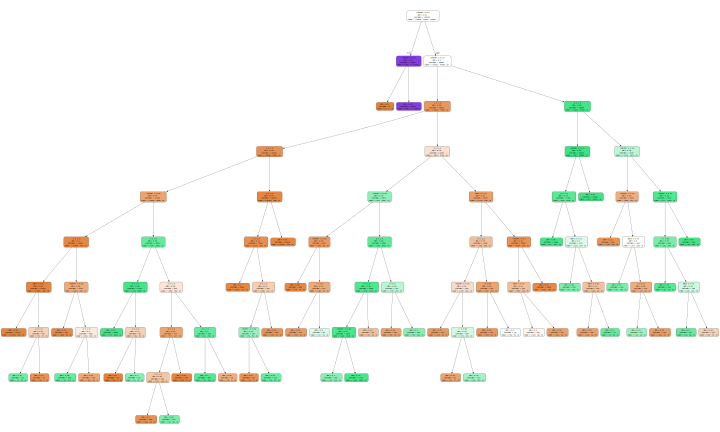

In [34]:
draw_tree(decision_tree, X_train, size=10)

### Random Forest

Now lets see how our random forest does. First lets try to find the ideal number
of estimators for our random forest classifier.

In [35]:
random_forest = parks_ranger.create_ideal_forest(30, X_train, y_train, X_valid, y_valid)

Progress: [####################] 100.0%
Found the ideal number of estimators is 25.0


In [36]:
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_valid)

score = f1_score(y_valid, predictions, average="weighted")

print(f"Random Forest F1 Score: {score}")

Random Forest F1 Score: 0.9812327783239032


In [37]:
score_df = pd.concat(
    [score_df, pd.DataFrame([{"Algorithm": "Random Forest", "F1 Score": score}])],
    ignore_index=True,
)
score_df

,Algorithm,F1 Score
0,LogisticRegression,0.923873
1,Decision Tree,0.971654
2,Random Forest,0.981233


Wow an F1 Score of 0.98. That's really good and it's gonna be pretty difficult
to beat. Lets see if our neural net can do better next.

One particularly nice feature of random forests is they can tell us which
independent variables were the most important in the model, using `feature_importances_`:

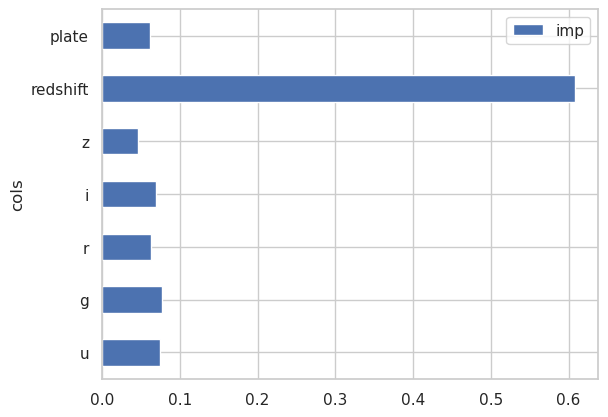

In [38]:
pd.DataFrame(dict(cols=X_train.columns, imp=random_forest.feature_importances_)).plot(
    "cols", "imp", "barh"
);

We can see that redshift was by far the most important predictor of the type
of entity the target is. 

## Results

From our experiments we can see that a Random Forest classifier composed of
25 estimators gives really good results with an F1 Score of 0.98. The normalization
of our data definitely gave our models a boost in these experiments.